In [48]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt
%matplotlib inline

# 4.2 損失関数

### 2乗和誤差

***

$$
E = \frac{1}{2} \sum_{k} (y_k - t_k)^2
$$
$ y_k $ : ニューラルネットワークの出力

$ t_k $ : 教師データ (one-hot表現)

***

- 一つのデータに対する関数．データ全体に渡って和を取り，データ数で割る．

- 先頭の1/2は微分したときに式を単純にするため．

- 手書き文字認識(0-9)であれば，$ k = 0,  \ldots, 9 $

In [18]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [19]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])

In [20]:
mean_squared_error(y, t)

0.09750000000000003

### 交差エントロピー誤差

***

$$
E = - \sum_{k} t_k \log y_k
$$
$ y_k $ : ニューラルネットワークの出力

$ t_k $ : 教師データ (one-hot表現)

***

- 一つのデータに対する関数．データ全体に渡って和を取り，データ数で割る．

- logは自然対数．

- 教師データがone-hot表現であれば，正解ラベルのインデックスの出力のみを計算することに等しい．

- 正解ラベルのインデックスの出力が1に近いほど，エントロピー誤差は0に近づく

- 手書き文字認識(0-9)であれば，$ k = 0,  \ldots, 9 $

In [44]:
x = np.arange(0, 1, 0.01)
x = x[1:]

Text(0.5, 1.0, 'y = - log x')

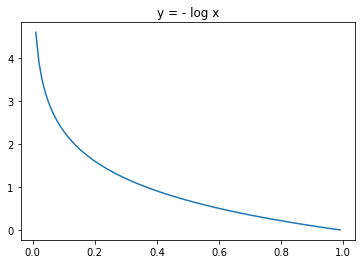

In [45]:
plt.plot(x, -np.log(x))
plt.title('y = - log x')

In [46]:
def cross_entropy_error(y, t):
    delta = 1e-7 # logの真数に0が入らないように，微小量を足す
    return -np.sum(t * np.log(y + delta))

### ミニバッチ学習

訓練データのすべてのデータの交差エントロピー誤差の和を求める

***
$$
E = - \frac{1}{N} \sum_{n} \sum_{k} t_{nk} \log y_{nk}
$$

$ n = 0, \ldots , N $ : データのインデックス

$ k = 0, \ldots , 9 $ : ラベルのインデックス
***

- 交差エントロピー誤差のデータ数 $ N $ 個の平均を取る．

In [64]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000,)


In [50]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### バッチ処理対応版 交差エントロピー誤差

In [60]:
# ===== 教師データが one-hot 表現の場合 =====
def cross_entropy_error(y, t):
    # データ数が1つの場合は2次元に直す
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    # バッチ全体の和を取り，バッチサイズで割る
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

# ===== 教師データがラベルとして与えられた場合 =====
def cross_entropy_error(y, t):
    # データ数が1つの場合は2次元に直す
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    # バッチ全体の和を取り，バッチサイズで割る
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size